### IMPORTS

In [1]:
# load, preprocess, scale, baseline
from wrangle import final_dataset

# manipulate data
import numpy as np

# visualize data
import matplotlib.pyplot as plt
import seaborn as sn

# neural network weights
from modelsNN import good_weights

# optmization problem
from modelsRO import good_problem

np.random.seed(123)

### Load, Clean, Preprocess, Scale, Baseline: Cardiovascular Disease

In [2]:
X_train_scaled_cd, X_test_scaled_cd, y_train_cd, y_test_cd = final_dataset(dataset='cvd')

CVD Loading and Cleaning...
CVD Loaded and Cleaned...

CVD Splitting...
CVD Split...

CVD Scaling...
CVD Scaled...



### Neural Network Comparisons: Cardiovascular Disease

In [3]:
%%time
nn_algo_tune = good_weights(X_train_scaled_cd, y_train_cd,
                            X_test_scaled_cd, y_test_cd)

Running Random Hill Climbing
Get_NN_Algo: Random Hill Climbing
Instantiated Random Hill Climbing
Time (Seconds): 5.841255187988281e-05

Working on: Random Hill Climbing
Fitting: Random Hill Climbing
Model Fitting Complete. Time: 33.27258539199829 seconds

Predicting (TRAINING): Random Hill Climbing

Calculating Recall (TRAINING): Random Hill Climbing

Appending Results (TRAINING): Random Hill Climbing

Recall Score (TRAINING): 0.5462026804608512%

Predicting (TESTING): Random Hill Climbing

Calculting Recall (TESTING): Random Hill Climbing

Appending Results (TESTING): Random Hill Climbing

Recall Score (TESTING): 0.5712383488681758%

Running Random Hill Climbing
Get_NN_Algo: Random Hill Climbing
Instantiated Random Hill Climbing
Time (Seconds): 2.09808349609375e-05

Working on: Random Hill Climbing
Fitting: Random Hill Climbing
Model Fitting Complete. Time: 67.9388792514801 seconds

Predicting (TRAINING): Random Hill Climbing

Calculating Recall (TRAINING): Random Hill Climbing

Appen

### Optimization Problem: Cardiovascular Disease

In [ ]:
%%time
opt_prob = good_problem()

Running All Algorithms

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing FourPeaks. Time: 0.28925470511118573 minutes.
Running Random Hill Climbing FlipFlop
Completed Random Hill Climbing FlipFlop. Time: 0.29489872058232625 minutes.
Running Random Hill Climbing Knapsack
Completed Random Hill Climbing Knapsack. Time: 0.29623364210128783 minutes.
Completed Random Hill Climbing. Time: 0.8803870677947998 minutes

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing FourPeaks. Time: 0.29319122632344563 minutes.
Running Random Hill Climbing FlipFlop
Completed Random Hill Climbing FlipFlop. Time: 0.298838210105896 minutes.
Running Random Hill Climbing Knapsack
Completed Random Hill Climbing Knapsack. Time: 0.2987847884496053 minutes.
Completed Random Hill Climbing. Time: 0.8908142248789469 minutes

Running Random Hill Climbing
Running Random Hill Climbing FourPeaks
Completed Random Hill Climbing Fo

### Analysis: Neural Network Comparisons

### Analysis: Optimization Problem

In [ ]:
rhc_combo1 = opt_prob['Random Hill Climbing']['rhc_combo1']['results'][1]['df_run_curves_FP']

In [ ]:
rhc_combo1

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000134,6.0,0.0,5,512,0
1,1,0.001915,6.0,1.0,5,512,0
2,2,0.003790,6.0,2.0,5,512,0
3,3,0.005503,6.0,3.0,5,512,0
4,4,0.005572,6.0,4.0,5,512,0
...,...,...,...,...,...,...,...
16576,497,0.094629,4.0,8046.0,15,512,15
16577,498,0.094912,4.0,8047.0,15,512,15
16578,499,0.095189,4.0,8048.0,15,512,15
16579,500,0.095466,4.0,8049.0,15,512,15


In [ ]:
rhc_combo1[rhc_combo1['FEvals'] == 0.0].sort_index()

,Iteration,Time,Fitness,FEvals,Restarts,max_iters,current_restart
0,0,0.000134,6.0,0.0,5,512,0
3019,0,0.000134,6.0,0.0,10,512,0
8546,0,0.000134,6.0,0.0,15,512,0


In [ ]:
check = rhc_combo1[rhc_combo1['Restarts'] == 5]

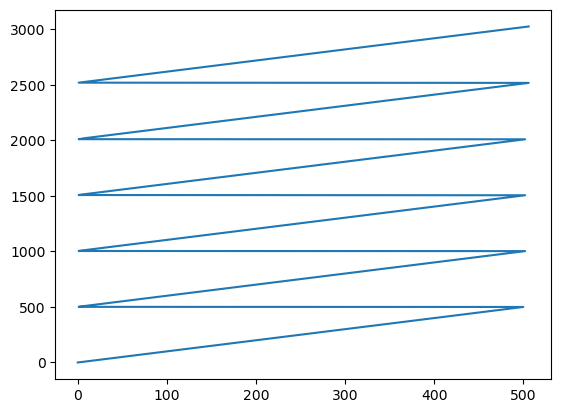

In [ ]:
plt.plot(check['Iteration'], check['FEvals'])
plt.show()

### Plotting

In [ ]:
# Create/display fitness curve plot for selected algorithm.
# plt.plot(nn.fitness_curve)
# plt.ylabel('Relative Fitness Found')
# plt.show()